## Import necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as pyplot

Import event records from numpy files

In [2]:
evRecord = np.load('FaserMuons-0410/fasernu_eventRecord.npy')
evEnergy = np.load('FaserMuons-0410/fasernu_eventEnergy.npy')
[eNum, sNum] = np.shape(evRecord)
# muRecord = np.load('FaserMuons-0407/fasernu_muonRecord.npy')
# emRecord = np.load('fasernu_emRecord.npy')
# emEnergy = np.load('fasernu_emEnergy.npy')

print('There are ' + str(eNum) + ' events recorded.')

There are 180000 events recorded.


`findMatches` checks the evRecord for events with the history matches the `mask` argument. For partial histories, specify the entries for the partial history with the `entries` argument.

In [3]:
def findMatches(mask, entries=range(sNum), threshold=0, evData=evRecord, enData=evEnergy):
    evMatches = []
    
    [eNum, tmp] = np.shape(evData)
    if threshold == 0:
        for ev in range(eNum):
            if all(evData[ev,entries] == mask):
                evMatches.append(ev)
    else:
        for ev in range(eNum):
            energyHist = enData[ev,1:] >= threshold
            if all(energyHist[entries] == mask):
                evMatches.append(ev)
    return evMatches

Check for histories which mimic our signal. This would be a primary which fails to light up the first pair of scintillators and then continues to light up the rest of the scintillators.

In [4]:
signal = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1];
fakes = findMatches(signal, threshold=10**-4);
print('There are ', np.size(fakes), ' events which fake the signal.')
print('The events which fake our signal are: ', fakes)

There are  279  events which fake the signal.
The events which fake our signal are:  [209, 2039, 2316, 2839, 3820, 4058, 5136, 5287, 5639, 5841, 6001, 6914, 7030, 7725, 10477, 10926, 11683, 11864, 12144, 12602, 13815, 14206, 14247, 15000, 17137, 17415, 17615, 18445, 18655, 20765, 21316, 22762, 23860, 23925, 25546, 25743, 26446, 26893, 26940, 28763, 28886, 29191, 29777, 30736, 31017, 31511, 31625, 32163, 32734, 33161, 33821, 33955, 34458, 34803, 34937, 34964, 35389, 36685, 38349, 39119, 39255, 39706, 40622, 41391, 41679, 41743, 43641, 43666, 44768, 45287, 46101, 46108, 46534, 47023, 47504, 47521, 48203, 48969, 49606, 50586, 51425, 52127, 53710, 54064, 54415, 55144, 56472, 57576, 57710, 57874, 58120, 58710, 58881, 59184, 59254, 60464, 62009, 62027, 62326, 62336, 63676, 63776, 64368, 66462, 66739, 68068, 68122, 69284, 69485, 69894, 70093, 70474, 71729, 72012, 72286, 72741, 72819, 73446, 74141, 74424, 74945, 77472, 78098, 78157, 78715, 79496, 79892, 80204, 80535, 81143, 82036, 82102, 82289

In [89]:
np.sum((evEnergy[fakes,10] < 1) & (evEnergy[fakes,10] > 0.1))

136

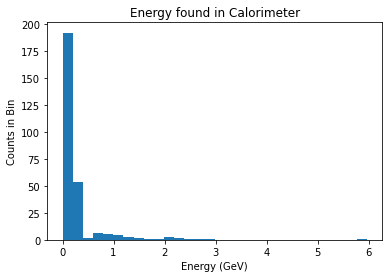

In [90]:
pyplot.hist(evEnergy[fakes,10],bins=30);
pyplot.xlabel('Energy (GeV)');
pyplot.ylabel('Counts in Bin');
pyplot.title('Energy found in Calorimeter');

`eventsPerPrimary` finds the number of events with primary energies in the bins defined by the `bins` input. It outputs the total number of events for each bin and the number of events which deposit an energy in the calorimeter between `calMin` and `calMax`. `eventsPerPrimary` also plots the two datasets as bar graphs overlaid on each other.

In [248]:
def eventsPerPrimary(bins=range(0,3800,200),
                     mask=[0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
                     entries=range(sNum), threshold=10**-4,
                     calMin=0.1, calMax=1):
    primaryEnergies = evEnergy[:,0]
    numPrimaries = []
    eventMatches = []
    eventMatchesAll = []
    for n in range(len(bins) - 1):
        boolArr = (primaryEnergies > bins[n]) & (primaryEnergies < bins[n+1])
        evData = evRecord[boolArr,:]
        enData = evEnergy[boolArr,:]
        fakes = findMatches(mask=mask, entries=entries, threshold=threshold,
                                    evData = evData, enData = enData)
        numMatches = np.sum((enData[fakes,10] > calMin) & (enData[fakes,10] < calMax))
        eventMatches.append(numMatches)
        eventMatchesAll.append(len(fakes))
        numPrimaries.append(np.sum(boolArr))
    
    pyplot.bar(bins[:-1],eventMatchesAll,np.diff(bins),align='edge',color='orange')
    pyplot.bar(bins[:-1],eventMatches,np.diff(bins),align='edge')
    pyplot.legend(['All Events','CalMin=' + str(calMin) + ' CalMax=' + str(calMax) + ' (GeV)'])
    pyplot.xlabel('Energy of Primary Muon (GeV)')
    pyplot.ylabel('Counts')
    pyplot.title('Number of "Faked" Events as a Function of Primary Muon Energy')
    return bins, numPrimaries, eventMatchesAll, eventMatches

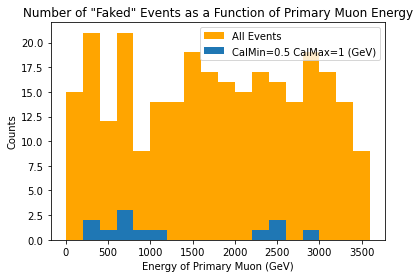

In [274]:
calMin = 0.5
calMax = 1
bins, numPrimaries, eventMatchesAll, eventMatches = eventsPerPrimary(calMin = calMin, calMax = calMax);

The above tools find the number of events which fake our signal. Now we want to determine how many background events we expect to see at FaserNu during the first run. We will begin by determining how to weight the counts based on the primary energy.

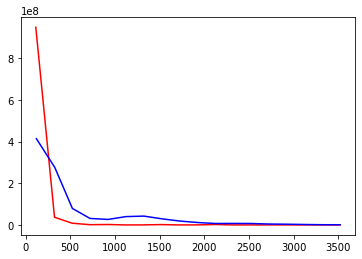

In [275]:
nmuData = np.loadtxt('MuonFluenceFiles/negative_muon_flux.csv')
pmuData = np.loadtxt('MuonFluenceFiles/positive_muon_flux.csv')

totalPrimaries = 10**9

nmuEn = nmuData[:,0]
nmuFl = nmuData[:,1]
nmuDist = nmuFl/np.sum(nmuFl)

pmuEn = pmuData[:,0]
pmuFl = pmuData[:,1]
pmuDist = pmuFl/np.sum(pmuFl)

pyplot.plot(pmuEn,pmuDist*totalPrimaries, color='red')
pyplot.plot(nmuEn,nmuDist*totalPrimaries, color='blue')

Total number of background events: 81420


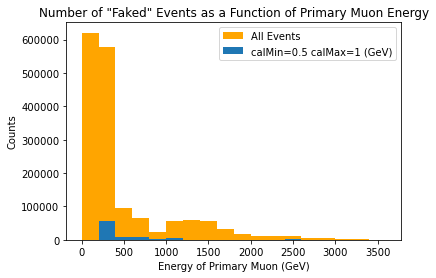

In [276]:
weightedCounts   = (np.array(eventMatches)/np.array(numPrimaries))*nmuDist*totalPrimaries
weightedCountAll = (np.array(eventMatchesAll)/np.array(numPrimaries))*nmuDist*totalPrimaries

pyplot.bar(bins[:-1],weightedCountAll,np.diff(bins),align='edge',color='orange')
pyplot.bar(bins[:-1],weightedCounts,np.diff(bins),align='edge')
pyplot.legend(['All Events','calMin=' + str(calMin) + ' calMax=' + str(calMax) + ' (GeV)'])
pyplot.xlabel('Energy of Primary Muon (GeV)')
pyplot.ylabel('Counts')
pyplot.title('Number of "Faked" Events as a Function of Primary Muon Energy');
print('Total number of background events: ' + str(round(np.sum(weightedCounts))))